<a href="https://colab.research.google.com/github/punnarat-w/Yomriver_analysis/blob/main/ForecastingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Retrieving Data

In [1]:
# importing pandas library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [141]:
# reading given csv file 
# and creating dataframe
websites = pd.read_csv("rawdata_results_test.txt",header = None)
  
# adding column headings
websites.columns = ['Station', 'Datetime', 'AvgTemp', 'MaxTemp', 'MaxTempTime', 'MinTemp', 'MinTempTime',
                    'VP', 'MaxRH', 'MaxRHTime', 'MinRH', 'MinRHTime', 'SR', 'WR', 'Prep', 'MaxSTemp5', 'MaxSTemp5Time', 'MinSTemp5', 'MinSTemp5Time',
                    'MaxSTemp15', 'MaxSTemp15Time', 'MinSTemp15', 'MinSTemp15Time', 'BV', 'Year', 'MaxWG', 'MaxWGTime', 'DirectionMaxWG']
  
# store dataframe into csv file
websites.to_csv('rawdata_results_test.csv', 
                index = None)

In [2]:
def getData(filename):
  data = pd.read_csv(filename)
  data['Datetime'] = pd.to_datetime(data['Datetime'])
  data = data.set_index('Datetime')
  return data

In [6]:
data

,Station,AvgTemp,MaxTemp,MaxTempTime,MinTemp,MinTempTime,VP,MaxRH,MaxRHTime,MinRH,MinRHTime,SR,WR,Prep,MaxSTemp5,MaxSTemp5Time,MinSTemp5,MinSTemp5Time,MaxSTemp15,MaxSTemp15Time,MinSTemp15,MinSTemp15Time,BV,Year,MaxWG,MaxWGTime,DirectionMaxWG
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01,ftc01,-4.459,4.921,15:00:00,-12.470,06:01:00,0.262,0.866,00:00:00,0.276,10:53:00,8.980,54.20,0.000,-0.958,18:40:00,-1.943,09:03:00,-0.413,21:26:00,-0.778,10:52:00,14.02,2010.0,6.125,00:02:00,287.90
2010-01-02,ftc01,-1.732,7.800,15:07:00,-10.280,03:40:00,0.335,0.938,04:12:00,0.300,14:56:00,6.031,124.00,0.000,-0.868,18:49:00,-1.654,08:47:00,-0.396,21:15:00,-0.738,10:46:00,13.75,2010.0,8.970,14:22:00,316.20
2010-01-03,ftc01,-1.364,3.801,12:42:00,-8.820,19:44:00,0.411,0.971,18:18:00,0.377,01:05:00,4.922,72.00,0.000,-0.535,23:56:00,-1.148,00:00:00,-0.220,23:13:00,-0.506,01:25:00,13.96,2010.0,5.300,14:25:00,168.40
2010-01-04,ftc01,-5.664,2.869,14:56:00,-13.130,04:13:00,0.338,0.959,06:37:00,0.441,15:05:00,7.520,41.20,1.778,-0.534,00:38:00,-1.016,10:38:00,-0.196,04:51:00,-0.381,14:28:00,14.01,2010.0,3.725,14:20:00,142.70
2010-01-05,ftc01,-2.719,3.540,13:17:00,-8.680,00:11:00,0.382,0.934,00:29:00,0.525,13:29:00,6.529,58.46,0.000,-0.608,20:47:00,-1.190,09:39:00,-0.243,23:02:00,-0.504,11:17:00,13.84,2010.0,4.325,11:22:00,332.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,ftc01,3.866,8.870,14:06:30,-5.214,22:19:40,0.298,0.944,22:19:50,0.001,00:02:30,8.770,240.90,0.000,-0.173,22:43:00,-0.391,09:41:00,0.089,23:54:10,-0.062,00:10:50,12.53,NaN,11.830,00:01:00,258.70
2020-12-28,ftc01,-3.694,-1.899,14:57:30,-7.736,03:26:40,0.446,1.045,13:24:00,0.001,21:52:30,1.874,47.14,0.000,-0.203,00:00:10,-0.891,07:35:10,0.089,00:00:40,-0.146,11:07:30,12.47,NaN,3.350,01:10:00,164.00
2020-12-29,ftc01,-3.675,3.093,13:17:50,-13.790,21:31:20,0.330,0.999,07:32:00,0.000,08:13:00,6.251,161.40,0.000,-0.297,16:36:40,-0.741,23:56:30,0.066,18:22:00,-0.021,00:02:50,12.44,NaN,10.480,10:37:00,294.40


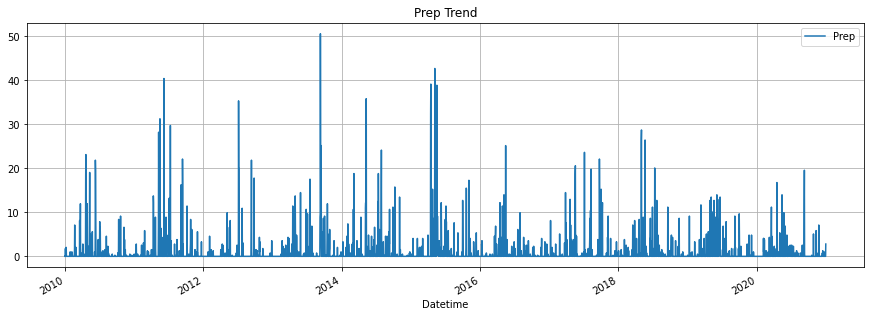

In [7]:

data.Prep.plot(figsize=(15,5))
plt.title('Prep Trend')
#plt.title('Symbol: {}'.format(stock_symbol))
plt.grid()
plt.legend();

In [25]:
# Create get_X_y function to get dependent (y) and independent (X) variables
def get_X_y_beta(dataframe):
  
  # Extract time series variable
  X = dataframe.reset_index()[['Datetime']]
  X['Year'] = [X.iloc[i, 0].year for i in range(len(X))]
  X['Month'] = [X.iloc[i, 0].month for i in range(len(X))]
  X['Day'] = [X.iloc[i, 0].day for i in range(len(X))]
  #X['EnglishDay'] = X.Date.dt.strftime('%a')

  # Set categorical variable
  X = X.astype({'Month':'category', 
                'Day':'category'}).set_index('Datetime')

  # Get OHLC
  X = X.merge(dataframe, left_index=True, right_index=True)

  # Extract dependent variable
  # y = dataframe[['CLOSE']].copy()
  
  return X #, y

In [38]:
df = pd.DataFrame(data['Prep'])
df = get_X_y_beta(df)

In [39]:
df.head()

,Year,Month,Day,Prep
Datetime,,,,
2010-01-01,2010,1,1,0.000
2010-01-02,2010,1,2,0.000
2010-01-03,2010,1,3,0.000
2010-01-04,2010,1,4,1.778
2010-01-05,2010,1,5,0.000


In [40]:
df = df[df['Day'] == 1]
df = pd.DataFrame(df['Prep'])

In [41]:
df

,Prep
Datetime,
2010-01-01,0.000
2010-02-01,0.000
2010-03-01,2.032
2010-04-01,0.762
2010-05-01,0.000
...,...
2020-08-01,0.000
2020-09-01,0.000
2020-10-01,0.000


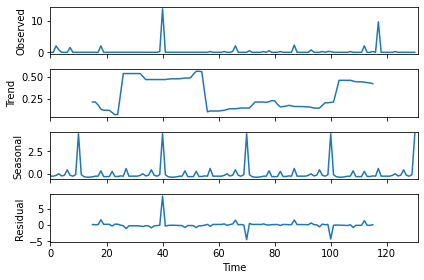

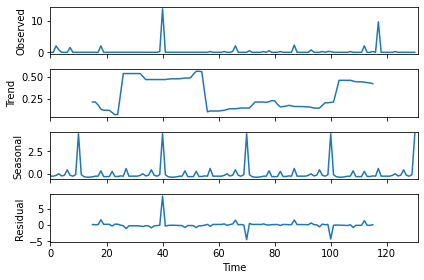

In [42]:
# decompose trend, seasonal, and residual
from statsmodels.tsa.seasonal import seasonal_decompose

prep_decom = seasonal_decompose(df.Prep.values, model='additive', freq= 30)

prep_decom.plot()

##Data Preparation



*   Data Cleansing



In [43]:
data

,Station,AvgTemp,MaxTemp,MaxTempTime,MinTemp,MinTempTime,VP,MaxRH,MaxRHTime,MinRH,MinRHTime,SR,WR,Prep,MaxSTemp5,MaxSTemp5Time,MinSTemp5,MinSTemp5Time,MaxSTemp15,MaxSTemp15Time,MinSTemp15,MinSTemp15Time,BV,Year,MaxWG,MaxWGTime,DirectionMaxWG
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01,ftc01,-4.459,4.921,15:00:00,-12.470,06:01:00,0.262,0.866,00:00:00,0.276,10:53:00,8.980,54.20,0.000,-0.958,18:40:00,-1.943,09:03:00,-0.413,21:26:00,-0.778,10:52:00,14.02,2010.0,6.125,00:02:00,287.90
2010-01-02,ftc01,-1.732,7.800,15:07:00,-10.280,03:40:00,0.335,0.938,04:12:00,0.300,14:56:00,6.031,124.00,0.000,-0.868,18:49:00,-1.654,08:47:00,-0.396,21:15:00,-0.738,10:46:00,13.75,2010.0,8.970,14:22:00,316.20
2010-01-03,ftc01,-1.364,3.801,12:42:00,-8.820,19:44:00,0.411,0.971,18:18:00,0.377,01:05:00,4.922,72.00,0.000,-0.535,23:56:00,-1.148,00:00:00,-0.220,23:13:00,-0.506,01:25:00,13.96,2010.0,5.300,14:25:00,168.40
2010-01-04,ftc01,-5.664,2.869,14:56:00,-13.130,04:13:00,0.338,0.959,06:37:00,0.441,15:05:00,7.520,41.20,1.778,-0.534,00:38:00,-1.016,10:38:00,-0.196,04:51:00,-0.381,14:28:00,14.01,2010.0,3.725,14:20:00,142.70
2010-01-05,ftc01,-2.719,3.540,13:17:00,-8.680,00:11:00,0.382,0.934,00:29:00,0.525,13:29:00,6.529,58.46,0.000,-0.608,20:47:00,-1.190,09:39:00,-0.243,23:02:00,-0.504,11:17:00,13.84,2010.0,4.325,11:22:00,332.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,ftc01,3.866,8.870,14:06:30,-5.214,22:19:40,0.298,0.944,22:19:50,0.001,00:02:30,8.770,240.90,0.000,-0.173,22:43:00,-0.391,09:41:00,0.089,23:54:10,-0.062,00:10:50,12.53,NaN,11.830,00:01:00,258.70
2020-12-28,ftc01,-3.694,-1.899,14:57:30,-7.736,03:26:40,0.446,1.045,13:24:00,0.001,21:52:30,1.874,47.14,0.000,-0.203,00:00:10,-0.891,07:35:10,0.089,00:00:40,-0.146,11:07:30,12.47,NaN,3.350,01:10:00,164.00
2020-12-29,ftc01,-3.675,3.093,13:17:50,-13.790,21:31:20,0.330,0.999,07:32:00,0.000,08:13:00,6.251,161.40,0.000,-0.297,16:36:40,-0.741,23:56:30,0.066,18:22:00,-0.021,00:02:50,12.44,NaN,10.480,10:37:00,294.40


In [71]:
#Missing value
data.isna().sum()
#Check date error

Station           0
AvgTemp           0
MaxTemp           0
MaxTempTime       0
MinTemp           0
MinTempTime       0
VP                0
MaxRH             0
MaxRHTime         0
MinRH             0
MinRHTime         0
SR                0
WR                0
Prep              0
MaxSTemp5         0
MaxSTemp5Time     0
MinSTemp5         0
MinSTemp5Time     0
MaxSTemp15        0
MaxSTemp15Time    0
MinSTemp15        0
MinSTemp15Time    0
BV                0
Year              0
MaxWG             0
MaxWGTime         0
DirectionMaxWG    0
dtype: int64

In [7]:
def fill_missing_value(df):
  feature_missing = df.columns[df.isnull().any()].tolist()
  df_original = df.copy()
  for i in feature_missing:
    np.random.seed(0)
    nan_rows = df[i].isna()
    random_feat = np.random.choice(df[i][~nan_rows], replace=True, size=sum(nan_rows)) 
    df.loc[nan_rows,i] = random_feat
  return df

In [70]:
data = fill_missing_value(data)



*   Transformation



In [72]:
# Create get_X_y function to get dependent (y) and independent (X) variables
def get_X_y(dataframe):
  
  # Extract time series variable
  X = dataframe.reset_index()[['Datetime']]
  X['Year'] = [X.iloc[i, 0].year for i in range(len(X))]
  X['Month'] = [X.iloc[i, 0].month for i in range(len(X))]
  X['Day'] = [X.iloc[i, 0].day for i in range(len(X))]
  #X['EnglishDay'] = X.Date.dt.strftime('%a')

  # Set categorical variable
  X = X.astype({'Month':'category', 
                'Day':'category'}).set_index('Datetime')

  # Get OHLC
  X = X.merge(dataframe, left_index=True, right_index=True)

  # Extract dependent variable
  y = dataframe[['Prep']].copy()

  col_drop = ['Station', 'MaxTemp', 'MaxTempTime', 'MinTemp', 'MinTempTime',
                    'MaxRHTime', 'MinRHTime', 'SR', 'Prep', 'MaxSTemp5', 'MaxSTemp5Time', 'MinSTemp5', 'MinSTemp5Time',
                    'MaxSTemp15', 'MaxSTemp15Time', 'MinSTemp15', 'MinSTemp15Time', 'BV','Year_y', 'MaxWGTime', 'DirectionMaxWG']
  X = X.drop(col_drop, axis=1)
  X = X.rename(columns={'Year_x' : 'Year'})
  return X, y

In [102]:
X, y = get_X_y(data)
X.head()

,Year,Month,Day,AvgTemp,VP,MaxRH,MinRH,WR,MaxWG
Datetime,,,,,,,,,
2010-01-01,2010,1,1,-4.459,0.262,0.866,0.276,54.20,6.125
2010-01-02,2010,1,2,-1.732,0.335,0.938,0.300,124.00,8.970
2010-01-03,2010,1,3,-1.364,0.411,0.971,0.377,72.00,5.300
2010-01-04,2010,1,4,-5.664,0.338,0.959,0.441,41.20,3.725
2010-01-05,2010,1,5,-2.719,0.382,0.934,0.525,58.46,4.325


In [103]:
y.head()

,Prep
Datetime,
2010-01-01,0.000
2010-01-02,0.000
2010-01-03,0.000
2010-01-04,1.778
2010-01-05,0.000


In [107]:
y.shape

(3994, 1)

In [108]:
#Encoding
X_encoded = pd.get_dummies(X)
X_encoded.head()

,Year,AvgTemp,VP,MaxRH,MinRH,WR,MaxWG,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01,2010,-4.459,0.262,0.866,0.276,54.20,6.125,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-02,2010,-1.732,0.335,0.938,0.300,124.00,8.970,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-03,2010,-1.364,0.411,0.971,0.377,72.00,5.300,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-04,2010,-5.664,0.338,0.959,0.441,41.20,3.725,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-05,2010,-2.719,0.382,0.934,0.525,58.46,4.325,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [113]:
y = pd.DataFrame(y, index= y.index, columns= ['Prep'])

In [133]:
def encoding_data(X, y):
  X_encoded = pd.get_dummies(X)
  y = pd.DataFrame(y, index= y.index, columns= ['Prep'])
  return X_encoded, y

In [115]:
#Split data

def train_test_split(dataframe, y, trainsize=0.8):

  import math

  train_ratio = trainsize
  train_size = math.ceil(len(dataframe) * train_ratio)

    # Get train dataframe
  X_train = dataframe.iloc[:train_size, :]
  y_train = y.iloc[:train_size, :]

  # Get train dataframe
  X_test = dataframe.iloc[train_size:, :]
  #X_test = dataframe.copy()
  y_test = y.iloc[train_size:, :]


  return X_train, X_test, y_train, y_test

In [116]:
X_train, X_test, y_train, y_test  = train_test_split(X_encoded, y, trainsize=0.8)

In [118]:
X_train.shape

(3196, 50)

##Data Modeling

In [119]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y = lr.predict(X_test)

In [120]:
#Error
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(y_test, y)
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

55.541302778105994


In [135]:
def prediction_model(X_train, X_test, y_train, y_test):
  from sklearn.linear_model import LinearRegression
  from sklearn.metrics import mean_squared_error
  import math
  lr = LinearRegression()
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  
  MSE = mean_squared_error(y_test, y_pred)
  RMSE = math.sqrt(MSE)
  print("Root Mean Square Error:\n")
  print(RMSE)
  return y_pred

In [125]:
#Visualize
def visualize(X, y, y_hat):

  # Set figure size
  plt.figure(figsize=(30, 10))

  # Plot actual price
  plt.plot(X.index, y, label='Actual Prep')

  # Plot predicted price
  plt.plot(X.index, y_hat, label='Predicted Prep')

  # Set title
  plt.title('Prep')

  # Set x-label
  plt.xlabel('Period')

  # Set y-label
  plt.ylabel('Prep')

  # Plot grid
  plt.grid()

  # Display legend
  plt.legend()

  # Display graph
  plt.show()

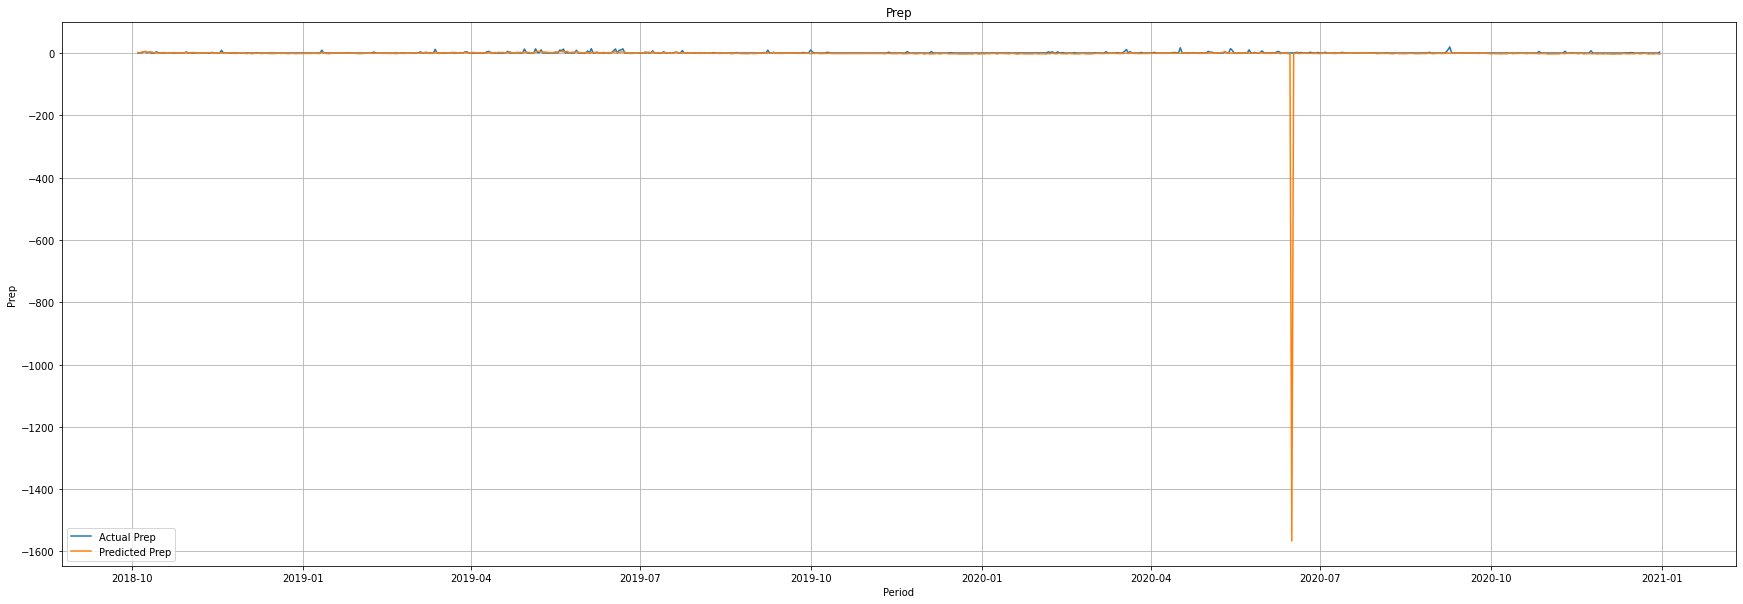

In [126]:
visualize(X_test,y_test,y)

##Feature Engineering

In [128]:
# Create feature_engineer function to extract new features
def feature_engineer(dataframe, feat_eng=False):

  if feat_eng:
    # Create a feature from previous day AvgTemp
    dataframe['PreviousDayAvgTemp'] = dataframe[['AvgTemp']].shift(periods=1,fill_value=0)

    # Create a feature from previous day VP
    dataframe['PreviousDayVP'] = dataframe[['VP']].shift(periods=1,fill_value=0)

    # Create a feature from previous day MaxRH
    dataframe['PreviousDayMaxRH'] = dataframe[['MaxRH']].shift(periods=1,fill_value=0)
    # Create a feature from previous day MinRH
    dataframe['PreviousDayMinRH'] = dataframe[['MinRH']].shift(periods=1,fill_value=0)
    # Create a feature from previous day WR
    dataframe['PreviousDayWR'] = dataframe[['WR']].shift(periods=1,fill_value=0)
    # Create a feature from previous day MaxWG
    dataframe['PreviousDayMaxWG'] = dataframe[['MaxWG']].shift(periods=1,fill_value=0)
 
  return dataframe

In [129]:
# Test our feature_engineer function
X_engineered = feature_engineer(X, feat_eng=True)
X_engineered

,Year,Month,Day,AvgTemp,VP,MaxRH,MinRH,WR,MaxWG,PreviousDayAvgTemp,PreviousDayVP,PreviousDayMaxRH,PreviousDayMinRH,PreviousDayWR,PreviousDayMaxWG
Datetime,,,,,,,,,,,,,,,
2010-01-01,2010,1,1,-4.459,0.262,0.866,0.276,54.20,6.125,0.000,0.000,0.000,0.000,0.00,0.000
2010-01-02,2010,1,2,-1.732,0.335,0.938,0.300,124.00,8.970,-4.459,0.262,0.866,0.276,54.20,6.125
2010-01-03,2010,1,3,-1.364,0.411,0.971,0.377,72.00,5.300,-1.732,0.335,0.938,0.300,124.00,8.970
2010-01-04,2010,1,4,-5.664,0.338,0.959,0.441,41.20,3.725,-1.364,0.411,0.971,0.377,72.00,5.300
2010-01-05,2010,1,5,-2.719,0.382,0.934,0.525,58.46,4.325,-5.664,0.338,0.959,0.441,41.20,3.725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,2020,12,27,3.866,0.298,0.944,0.001,240.90,11.830,5.241,0.341,0.948,0.001,189.60,14.000
2020-12-28,2020,12,28,-3.694,0.446,1.045,0.001,47.14,3.350,3.866,0.298,0.944,0.001,240.90,11.830
2020-12-29,2020,12,29,-3.675,0.330,0.999,0.000,161.40,10.480,-3.694,0.446,1.045,0.001,47.14,3.350


##Data Pipeline

In [139]:
def prediction_model_pipeline(filename, feat_eng = True):
  #Get data
  df = getData(filename)
  df = fill_missing_value(df)
  #Get x y
  X, y = get_X_y(df)

  #Feature engineering
  X_engineered = feature_engineer(X, feat_eng=True)

  #Encoded
  X_eng_encoded, y = encoding_data(X_engineered, y)

  #Split
  X_train, X_test, y_train, y_test  = train_test_split(X_eng_encoded, y, trainsize=0.8)

  #Model
  y_pred = prediction_model(X_train, X_test, y_train, y_test)

  #Visualization
  visualize(X_test,y_test,y_pred)

Root Mean Square Error:

73.11948743888803


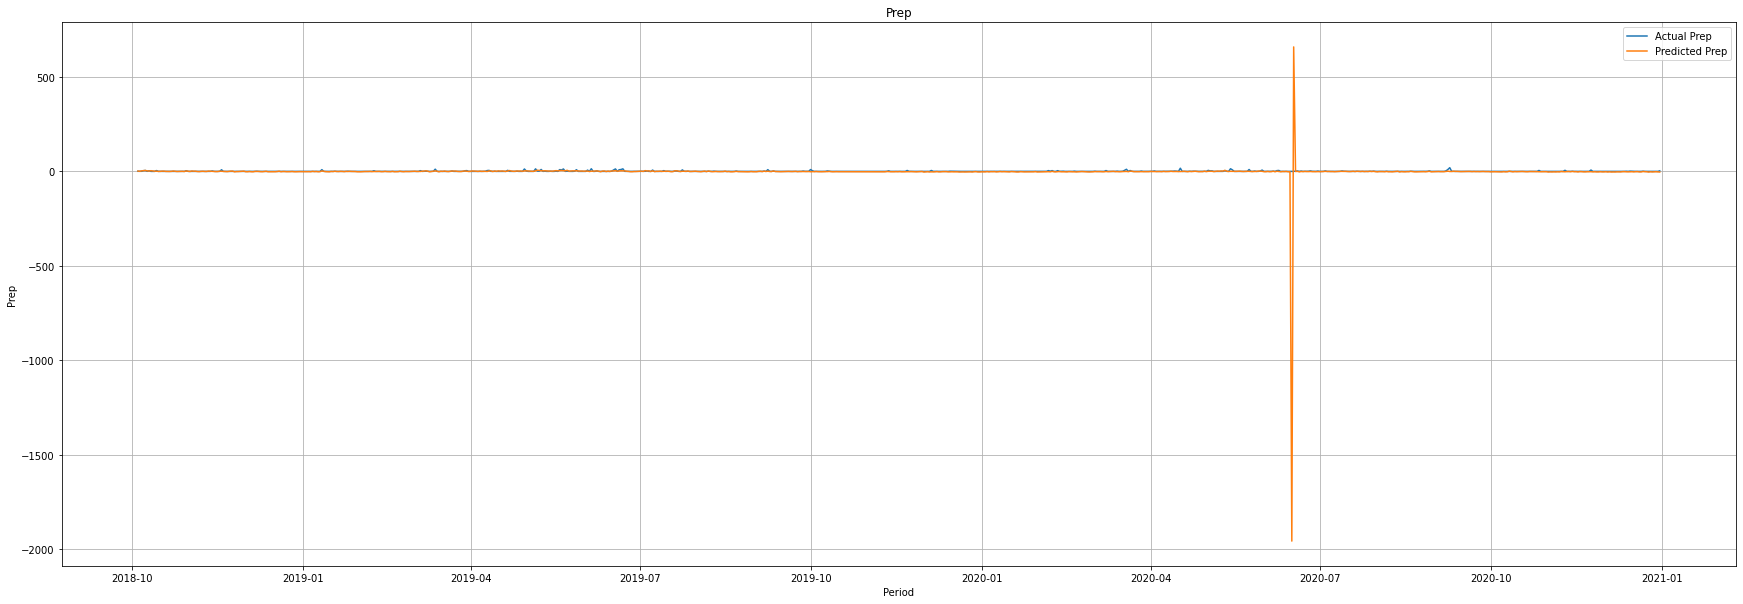

In [140]:
prediction_model_pipeline('rawdata_results_test.csv', feat_eng = True)

###Forecast Model

In [152]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 24.2MB/s 
     |████████████████████████████████| 9.5MB 31.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
data = getData('rawdata_results_test.csv')

In [37]:
#Check Stationarity Data
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
ad_test(data['Prep'])

1. ADF :  -8.521541233887849
2. P-Value :  1.0972577301523728e-13
3. Num Of Lags :  31
4. Num Of Observations Used For ADF Regression: 3962
5. Critical Values :
	10%: -2.5671584676893895 - The data is  stationary with 90% confidence
	10%: -2.5671584676893895 - The data is  stationary with 90% confidence
	10%: -2.5671584676893895 - The data is  stationary with 90% confidence


In [52]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(data['Prep'], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=20555.256, Time=7.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20954.366, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=20573.209, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=20597.673, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21234.473, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=20559.776, Time=4.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=20576.706, Time=2.58 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=20572.655, Time=7.44 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=20556.021, Time=7.32 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=20575.126, Time=0.88 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=20555.528, Time=6.17 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=20555.511, Time=6.77 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=20557.913, Time=8.42 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=20575.714, Time=1.70 sec

Best model:  ARIMA

Train model

In [16]:
df_new = fill_missing_value(data)

In [17]:
df_new = pd.DataFrame(df_new[['Prep']])

In [18]:
df_new

,Prep
Datetime,
2010-01-01,0.000
2010-01-02,0.000
2010-01-03,0.000
2010-01-04,1.778
2010-01-05,0.000
...,...
2020-12-27,0.000
2020-12-28,0.000
2020-12-29,0.000


In [19]:
def f_train_test_split(dataframe,trainsize=0.8):

  import math

  train_ratio = trainsize
  train_size = math.ceil(len(dataframe) * train_ratio)

    # Get train dataframe
  X_train = dataframe.iloc[:train_size, :]
  #y_train = y.iloc[:train_size, :]

  # Get train dataframe
  X_test = dataframe.iloc[train_size:, :]
  #X_test = dataframe.copy()
  #y_test = y.iloc[train_size:, :]


  return X_train, X_test

In [20]:
train, test = f_train_test_split(df_new)

In [44]:
train.shape

(3196, 1)

In [53]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')
model=ARIMA(df_new,order=(3,0,1))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Prep   No. Observations:                 3994
Model:                     ARMA(3, 1)   Log Likelihood              -10271.755
Method:                       css-mle   S.D. of innovations              3.167
Date:                Thu, 27 May 2021   AIC                          20555.511
Time:                        16:11:31   BIC                          20593.266
Sample:                             0   HQIC                         20568.895
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8975      0.115      7.824      0.000       0.673       1.122
ar.L1.Prep     1.2475      0.022     56.579      0.000       1.204       1.291
ar.L2.Prep    -0.2980      0.025    -11.868      0.000      -0.347      -0.249
ar.L3.Prep     0.0285      0.016      1.762      0.078      -0.003       0.060
ma.L1.Prep    -0.9494      0.015    -61.361      0.000      -0.980      -0.919
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0302           -0.0000j            1.0302           -0.0000
AR.2            4.7114           -3.4424j            5.8350           -0.1004
AR.3            4.7114           +3.4424j            5.8350            0.1004
MA.1            1.0533           +0.0000j            1.0533            0.0000
-----------------------------------------------------------------------------
"""

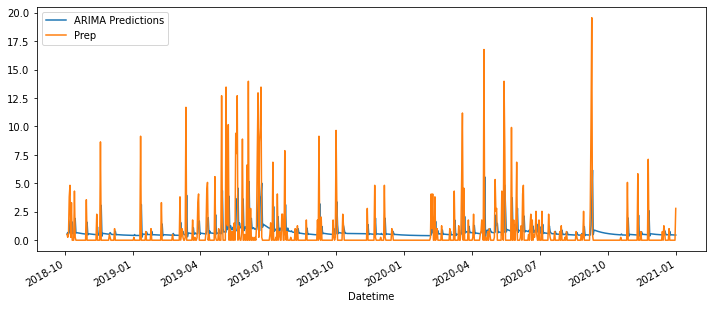

In [64]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(figsize=(12,5),legend=True)
test['Prep'].plot(figsize=(12,5),legend=True)

In [56]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# test['Prep'].mean()
rmse=sqrt(mean_squared_error(pred,test['Prep']))
print(rmse)

2.1761221198286465


In [59]:
df = fill_missing_value(data)
model2=ARIMA(df['Prep'],order=(3,0,1))
model2=model2.fit()
df.tail()

,Station,AvgTemp,MaxTemp,MaxTempTime,MinTemp,MinTempTime,VP,MaxRH,MaxRHTime,MinRH,MinRHTime,SR,WR,Prep,MaxSTemp5,MaxSTemp5Time,MinSTemp5,MinSTemp5Time,MaxSTemp15,MaxSTemp15Time,MinSTemp15,MinSTemp15Time,BV,Year,MaxWG,MaxWGTime,DirectionMaxWG
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-27,ftc01,3.866,8.870,14:06:30,-5.214,22:19:40,0.298,0.944,22:19:50,0.001,00:02:30,8.770,240.90,0.000,-0.173,22:43:00,-0.391,09:41:00,0.089,23:54:10,-0.062,00:10:50,12.53,2012.0,11.830,00:01:00,258.70
2020-12-28,ftc01,-3.694,-1.899,14:57:30,-7.736,03:26:40,0.446,1.045,13:24:00,0.001,21:52:30,1.874,47.14,0.000,-0.203,00:00:10,-0.891,07:35:10,0.089,00:00:40,-0.146,11:07:30,12.47,2010.0,3.350,01:10:00,164.00
2020-12-29,ftc01,-3.675,3.093,13:17:50,-13.790,21:31:20,0.330,0.999,07:32:00,0.000,08:13:00,6.251,161.40,0.000,-0.297,16:36:40,-0.741,23:56:30,0.066,18:22:00,-0.021,00:02:50,12.44,2011.0,10.480,10:37:00,294.40
2020-12-30,ftc01,-10.070,0.187,14:59:10,-18.200,04:35:40,0.223,1.043,08:14:20,0.001,18:23:30,9.320,30.06,0.000,-0.741,00:00:10,-1.576,09:27:30,-0.009,00:00:10,-0.625,23:43:10,12.41,2011.0,3.050,13:00:00,339.90
2020-12-31,ftc01,-2.413,6.340,14:26:40,-11.390,07:19:40,0.326,0.999,08:04:50,0.001,14:33:40,8.840,45.10,2.794,-0.853,18:49:10,-1.731,09:04:30,-0.426,22:29:10,-0.878,10:36:10,12.56,2012.0,3.125,05:41:00,43.07


In [62]:
index_future_dates=pd.date_range(start='2020-12-31',end='2021-03-31')
#print(index_future_dates)
pred=model2.predict(start=len(df),end=len(df)+90,typ='levels').rename('ARIMA Predictions')
pred.index=index_future_dates
print(pred)

2020-12-31    1.281143
2021-01-01    0.785299
2021-01-02    0.697270
2021-01-03    0.692095
2021-01-04    0.697738
                ...   
2021-03-27    0.880038
2021-03-28    0.880549
2021-03-29    0.881044
2021-03-30    0.881525
2021-03-31    0.881991
Freq: D, Name: ARIMA Predictions, Length: 91, dtype: float64


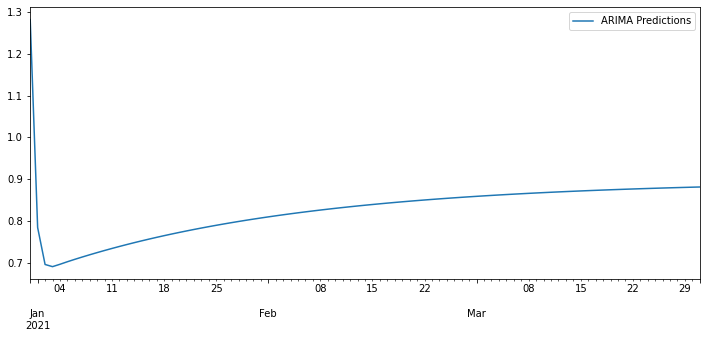

In [63]:
pred.plot(figsize=(12,5),legend=True)